In [121]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern


def fit_GP(x, y, yerr):
    #kernel = 1 * RBF(length_scale= 50.)
    kernel = Matern(length_scale= 100., nu= 0.5)
    sigma_kernel = 0.1
    gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha= np.square(yerr / sigma_kernel), optimizer= None)
    gaussian_process.fit(x.reshape(-1, 1), y.reshape(-1, 1))
    return gaussian_process



def _outlier_removal_gp(time, data, data_err, mask):
    gp = fit_GP(time[mask], data[mask], data_err[mask])
    model, err_model =  gp.predict(time.reshape(-1, 1), return_std=True)
    mask_new = np.abs((data-model)/err_model) < 3.
    
    return mask_new, gp


def refine_unequal_grid(x, n):
    """place n points in between x points"""    
    
    X = np.array([np.linspace(x[i], x[i+1], n+1, endpoint=False) for i in range(len(x)-1)]).flatten()
    X = np.insert(X, [len(X), ], [x[-1], ])
    return X

    
def outlier_removal_gp(time, data, data_err):
    avg = np.average(data, weights=1./np.square(data_err))
    mask = np.ones(time.shape, dtype = bool)
    niter = 5
    
    x = refine_unequal_grid(np.sort(time), 20)
    
    for i in range(niter):
        mask, gp = _outlier_removal_gp(time, data-avg, data_err, mask)
            
        y, yerr= gp.predict(x.reshape(-1, 1), return_std= True)
        color = plt.cm.inferno(1. - ((i + 0.5) / niter))
        plt.plot(x, y+avg, color= color, label= 'GP (iteration '+str(i+1)+')')
        if i == (niter-1):
            plt.fill_between(x, avg+y-3*yerr, avg+y+3*yerr, color = color, alpha = 0.4)

    # plot
    plt.errorbar(time[mask], data[mask], data_err[mask], fmt = '.', capsize = 1.3, color = 'black', label= 'data')
    plt.errorbar(time[~mask], data[~mask], data_err[~mask], fmt = '.', capsize = 1.3, color = 'tab:red', label= 'identified as outliers')
    
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('magnitude')
    plt.gca().invert_yaxis()
    #plt.xlim(56275, 56325)
    plt.show()
    
    

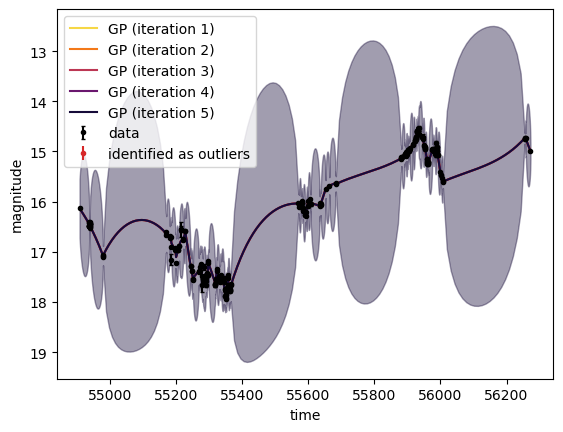

In [123]:
from quasars.prep import dir_data


def prepare_data(id, remove_outliers= True, average_within_night= True):
    
    # load the data
    df = pd.read_csv(dir_data + str(id) + '.csv')
    time = np.array(df['time'])
    mag = np.array(df['mag'])
    mag_err = np.array(df['mag_err'])
    
    # sort the data
    # perm = np.argsort(time)
    # time, mag, mag_err = time[perm], mag[perm], mag_err[perm]
    
    if remove_outliers:
        mask = outlier_removal_gp(time, mag, mag_err)
        time, mag, mag_err = time[mask], mag[mask], mag_err[mask]
    
    
    return time, mag, mag_err

id = 253736
#id = 19827
time, mag, mag_err = prepare_data(id)

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd

from simulations.util import *


def median_3point(_x):

    # zero paddle the data
    what_insert = jnp.array([0, -1])
    where_insert = jnp.array([0, -1])
    x = jnp.insert(_x, where_insert, _x[what_insert])
    
    X = jnp.array([x[:-2], x[1:-1], x[2:]]) # array of shape (3, len(_x)), created by shifting _x
    return jnp.median(X, axis = 0) # take a median along the first axis


def outlier_removal(time, data):
    """time should be ordered"""
    
    y = median_3point(data) # three point median filter
    
    p = jnp.polyfit(time - time[0], y, deg= 5) # fit the polynomial coefficients (eliminating t[0] increases the stability)
    polynomial = jnp.polyval(p, time-time[0]) # compute the polynomial
    
    residuals = data-polynomial
    sigma = jnp.std(residuals) # compute sigma
    mask = jnp.abs(residuals) < 3 * sigma
    return mask
    